# pyVDJ for fetal BM T cells

This tutorial is for pyVDJ v0.1.1. The package is available here: https://github.com/veghp/pyVDJ

# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import scanpy as sc  
import pyvdj
import upsetplot

In [2]:
sc.settings.set_figure_params(dpi=300, dpi_save=1000)

# Import FBM T cell data

In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad")

In [4]:
adata.shape

(103228, 33712)

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [6]:
from scipy import sparse
array_vals = adata.X
adata.X = sparse.csr_matrix(adata.X)
adata.raw = adata
adata.X = array_vals

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['CD4 T cell', 'CD8 T cell', 'Treg'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell    327
CD8 T cell    171
Treg           62
dtype: int64

# Pre-process the data

In [9]:
# normalise count data 
sc.pp.normalize_total(adata)

In [10]:
# log the count data 
sc.pp.log1p(adata)

In [11]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [12]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [13]:
# run pca
sc.tl.pca(adata, n_comps=50)

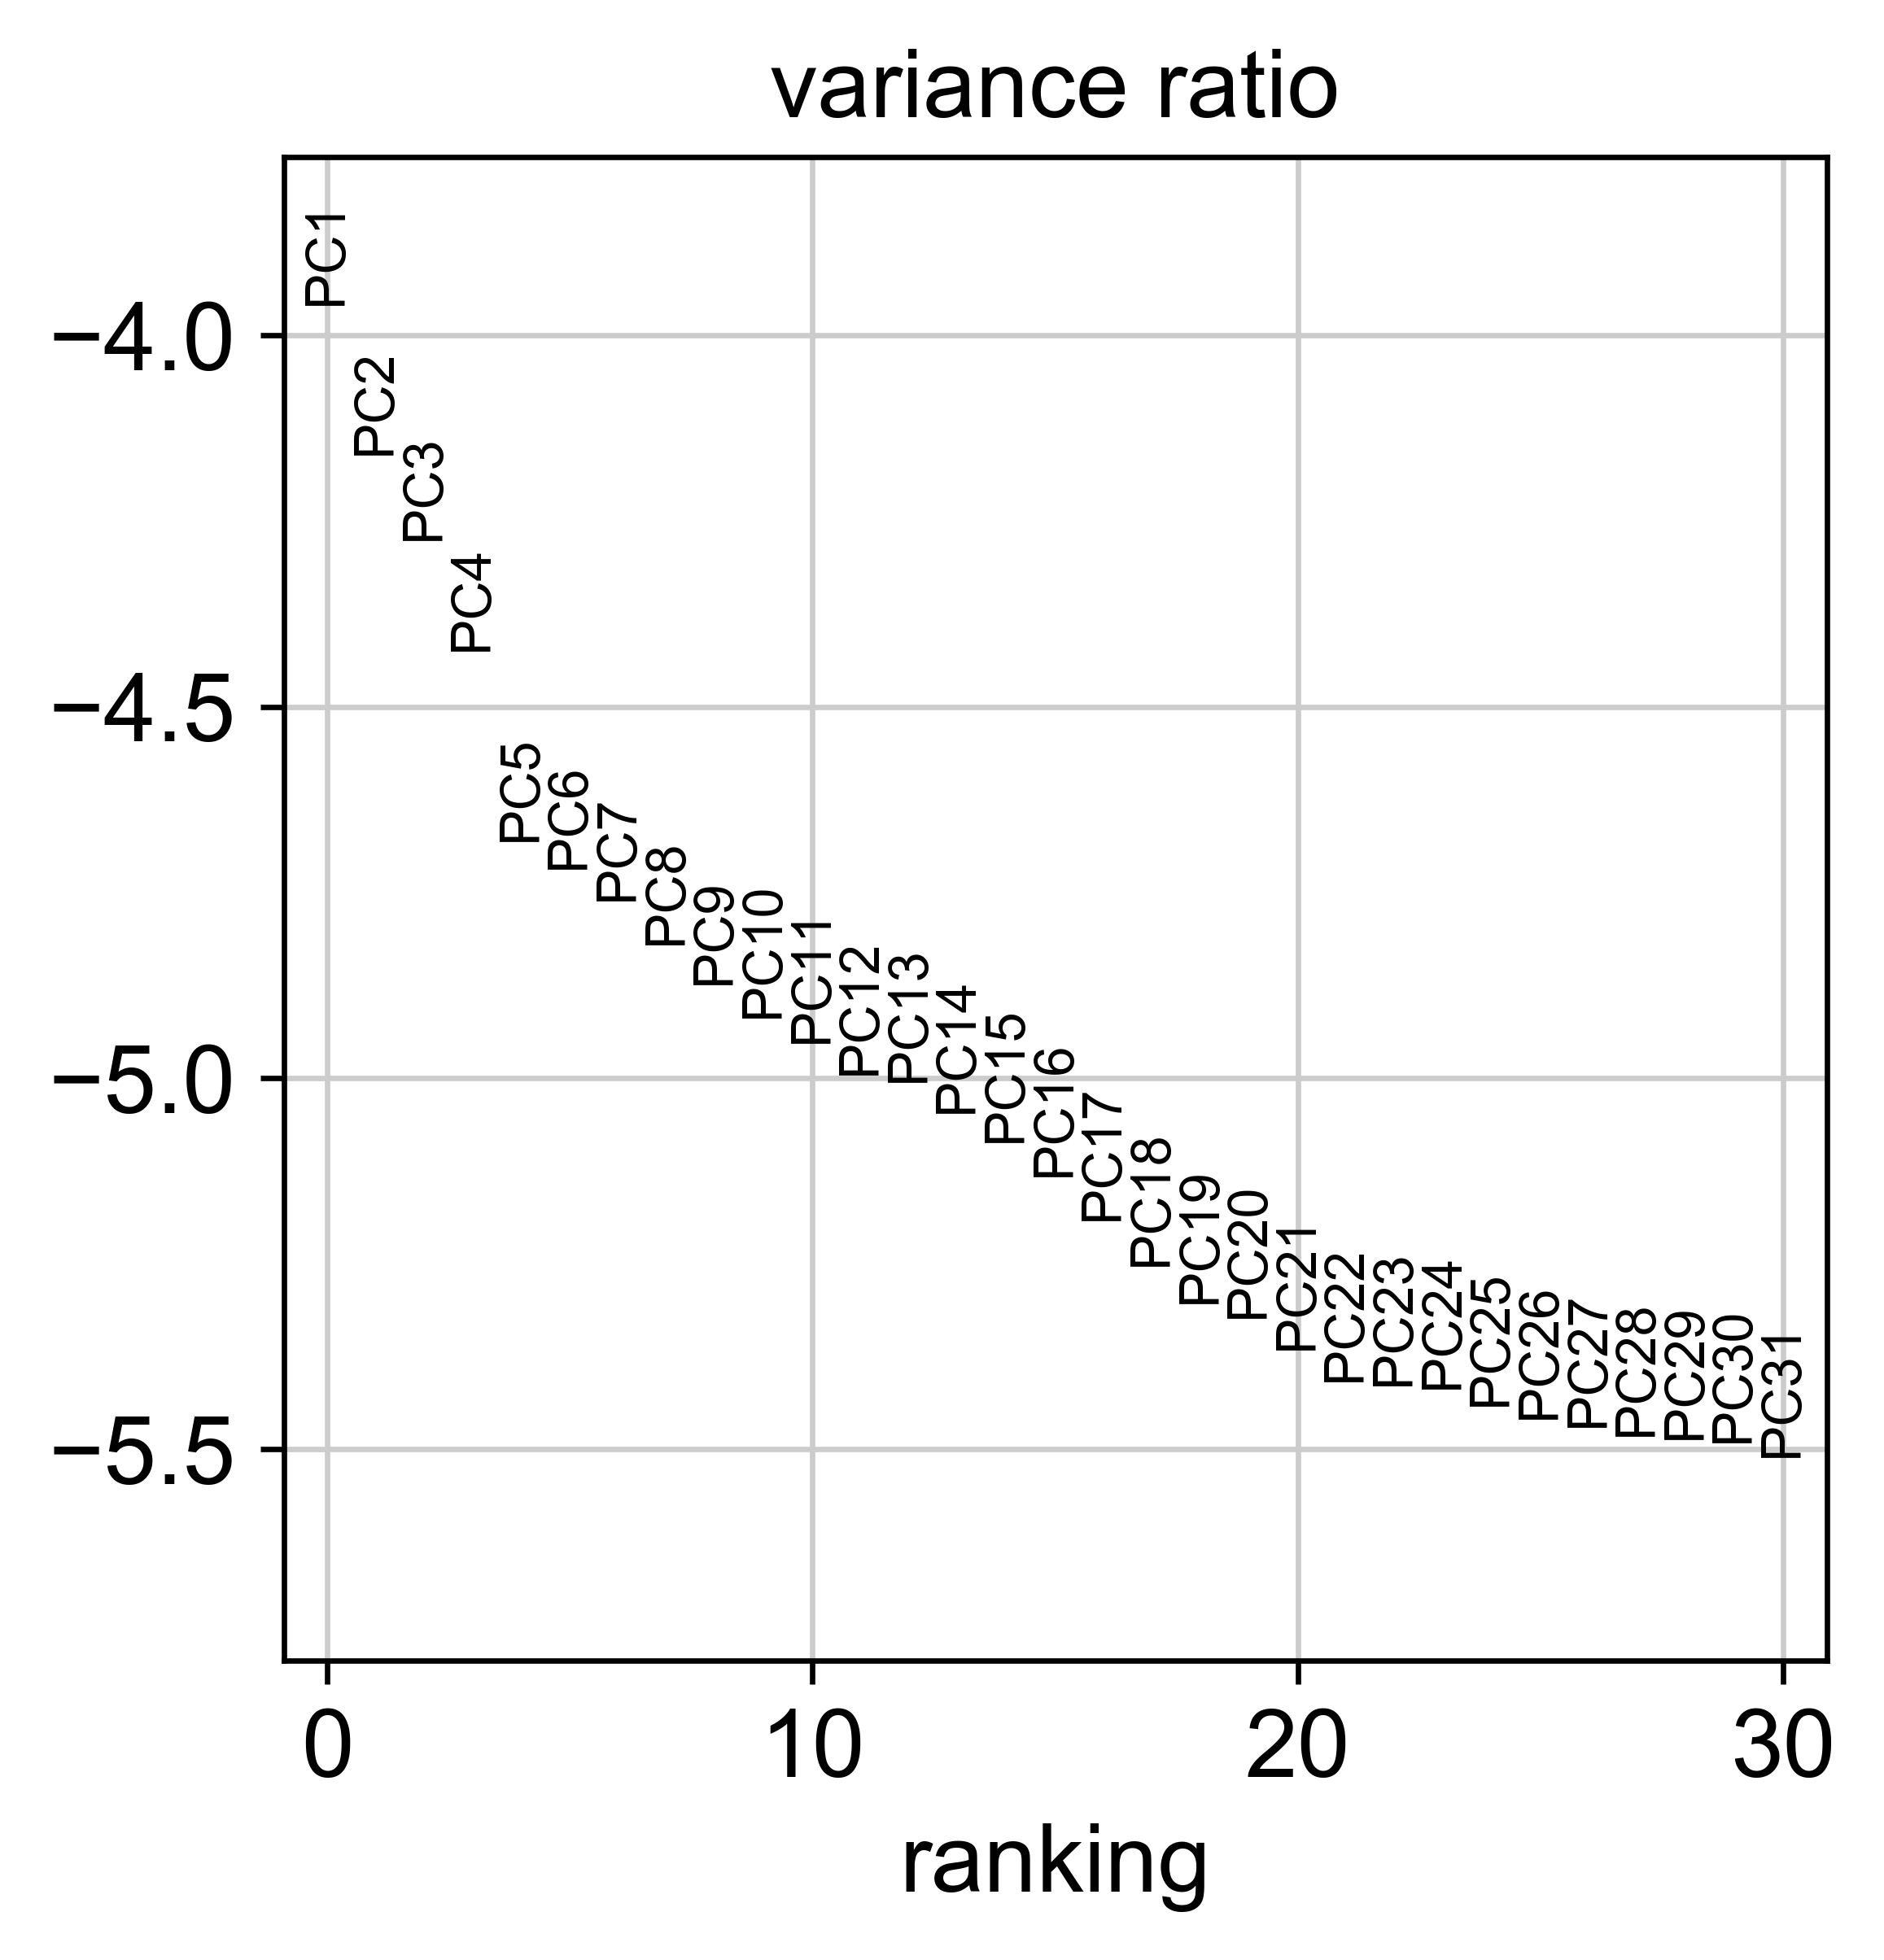

In [14]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [16]:
# run umap
sc.tl.umap(adata) 

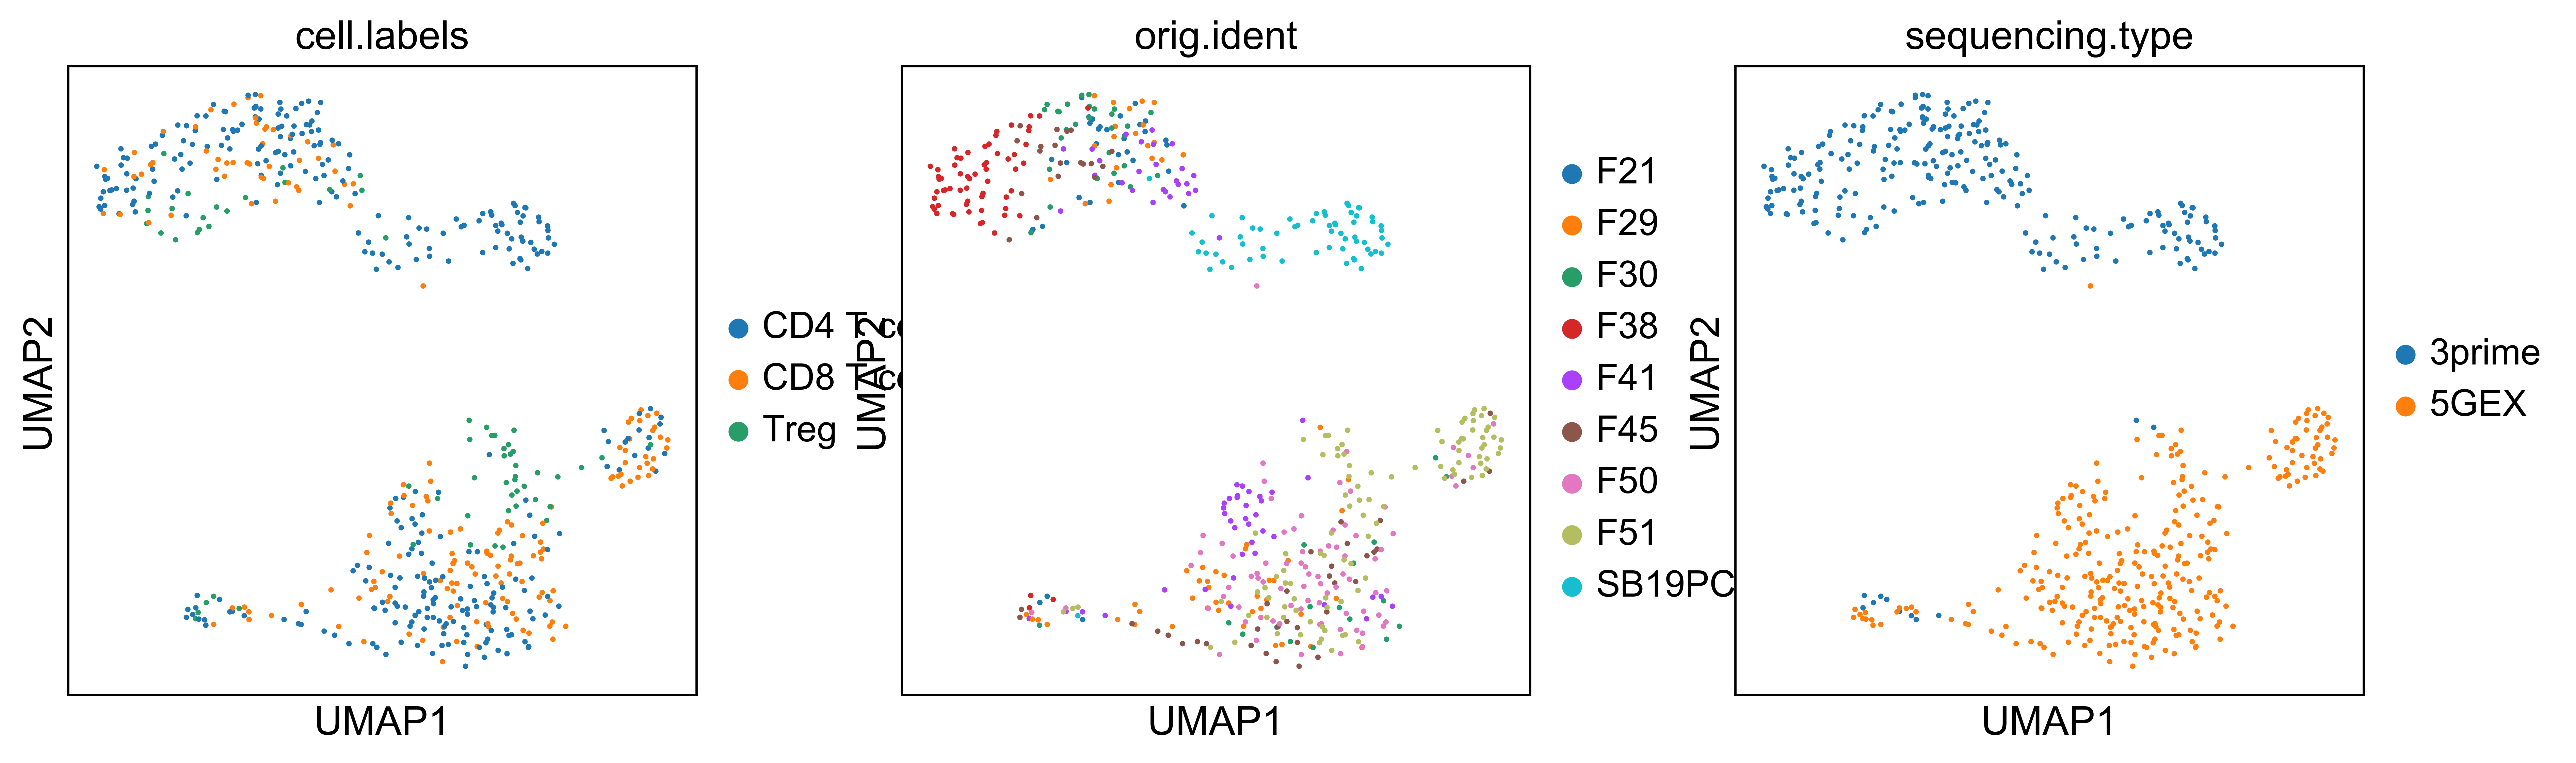

In [17]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident', 'sequencing.type'], size=15) 

# Run harmony batch correction

In [18]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [19]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [20]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [21]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

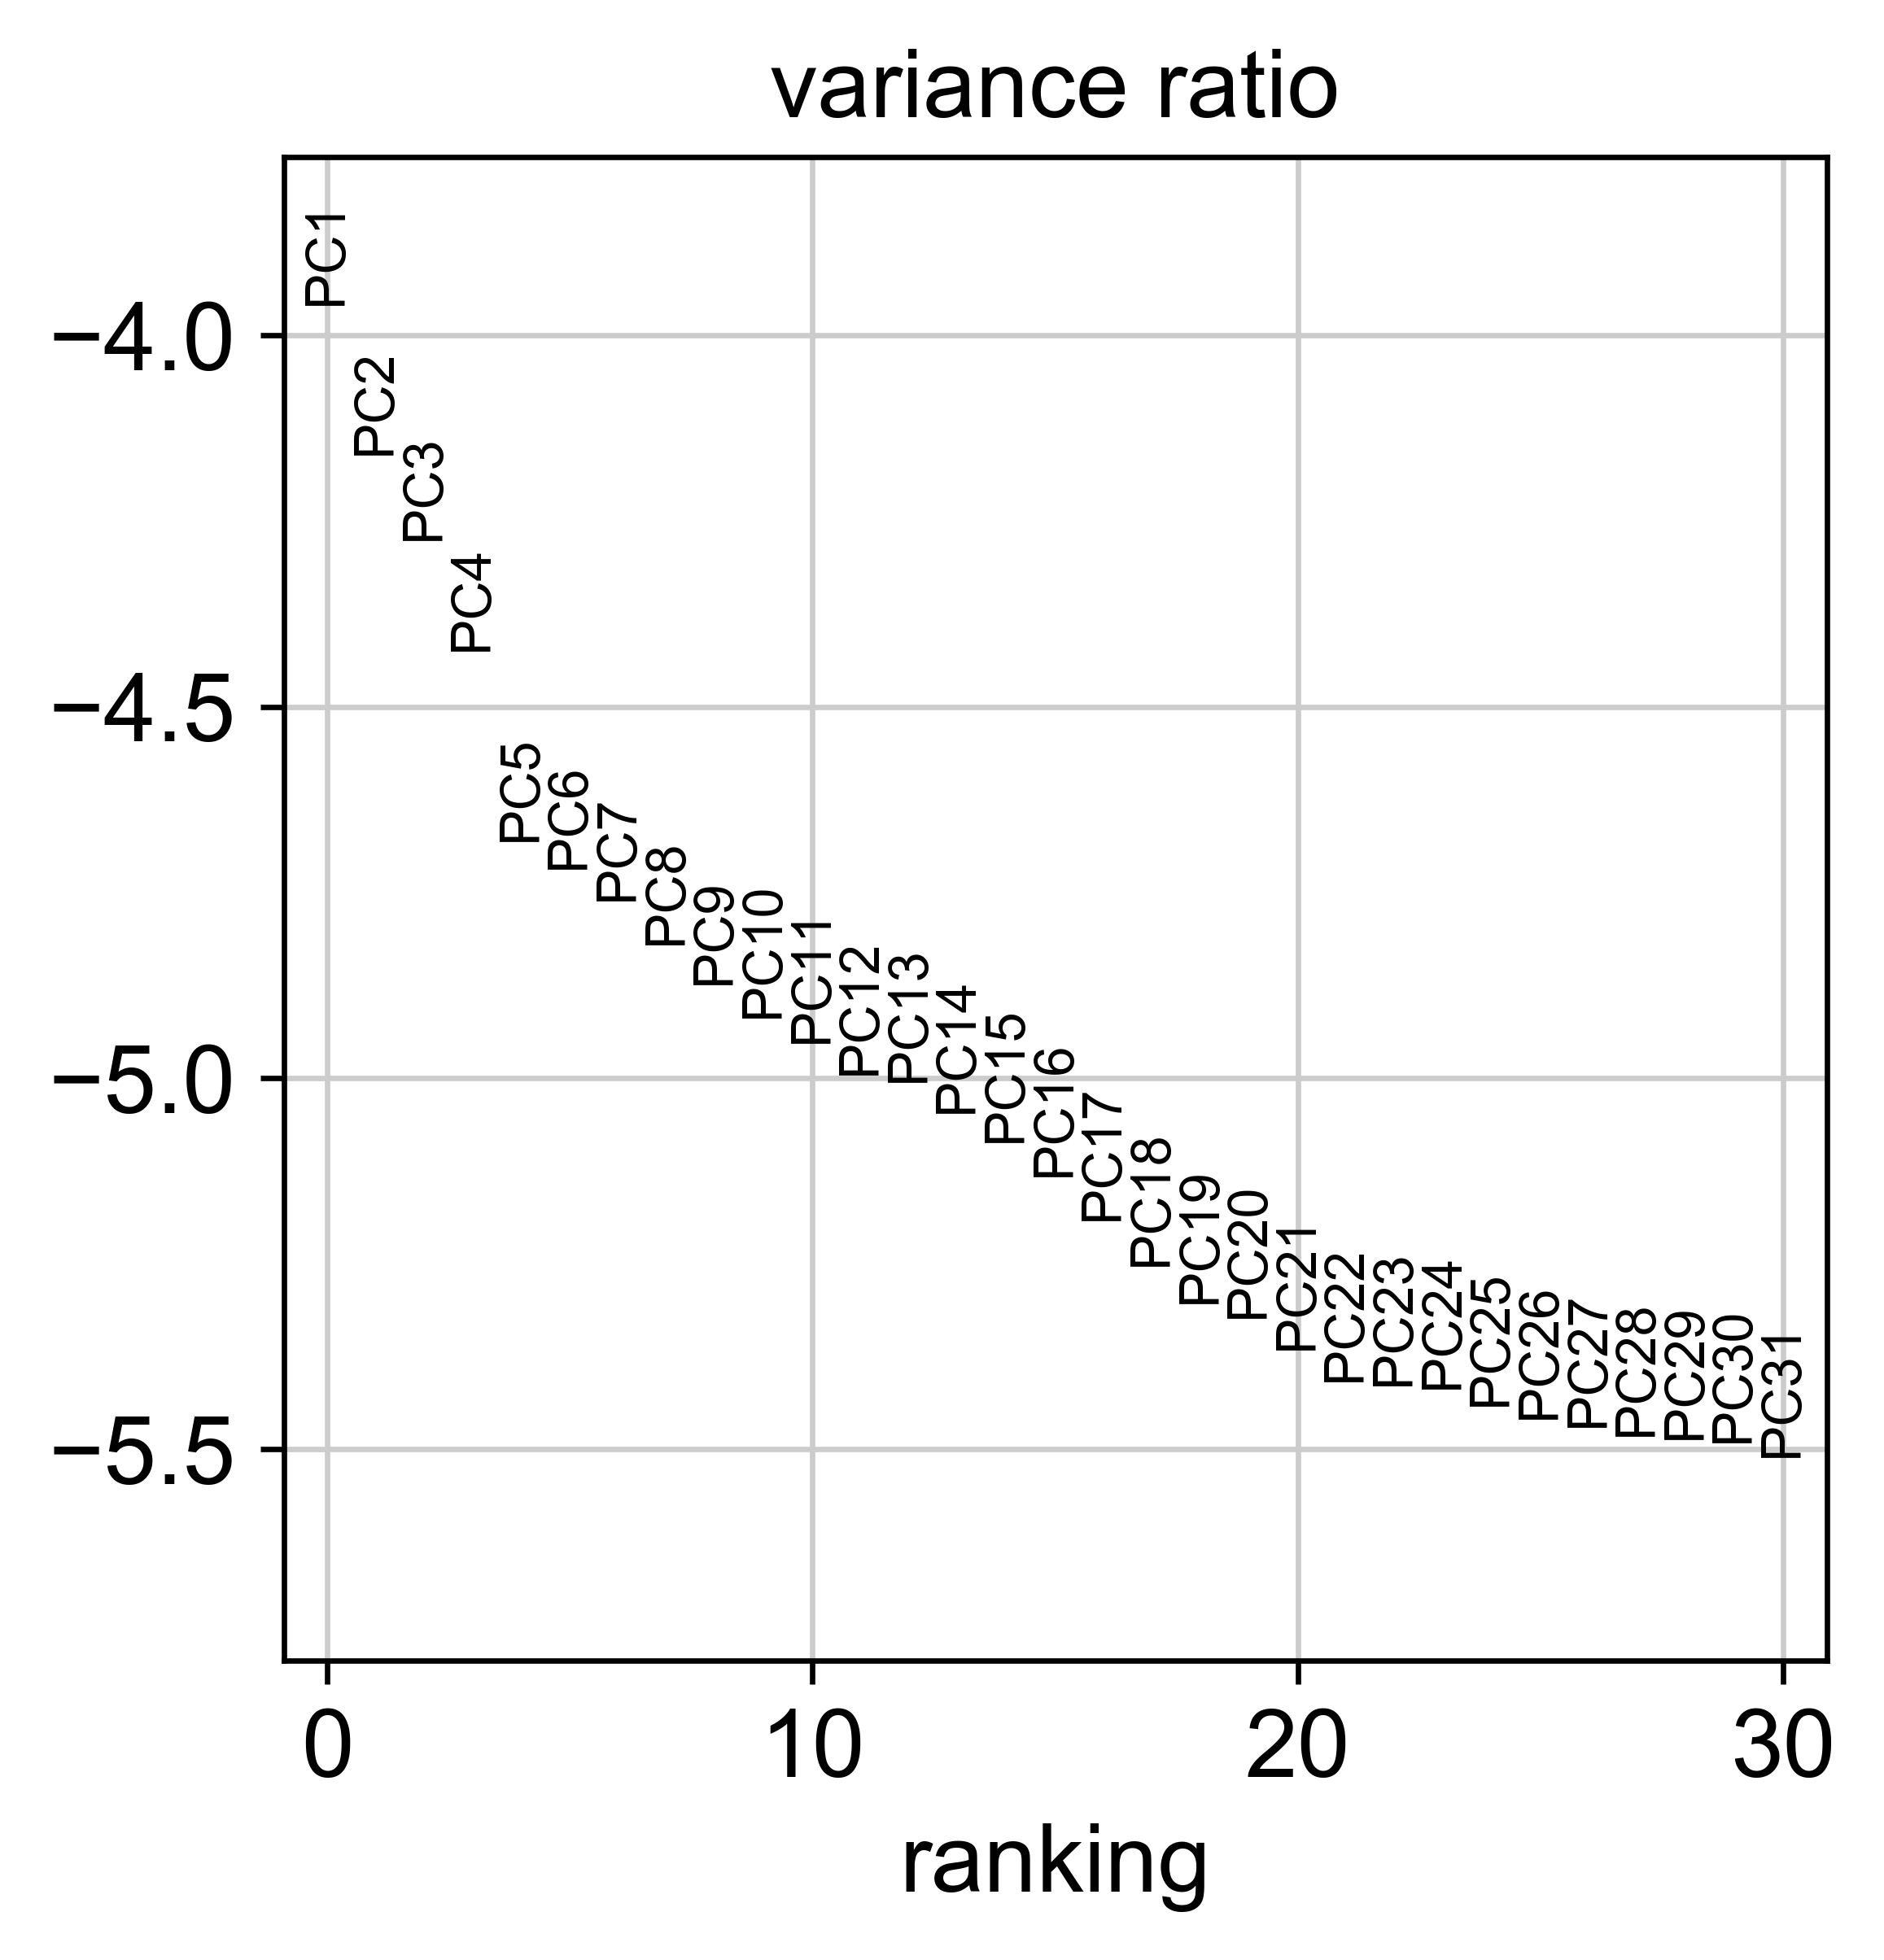

In [22]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10) 

In [24]:
# run umap
sc.tl.umap(adata) 

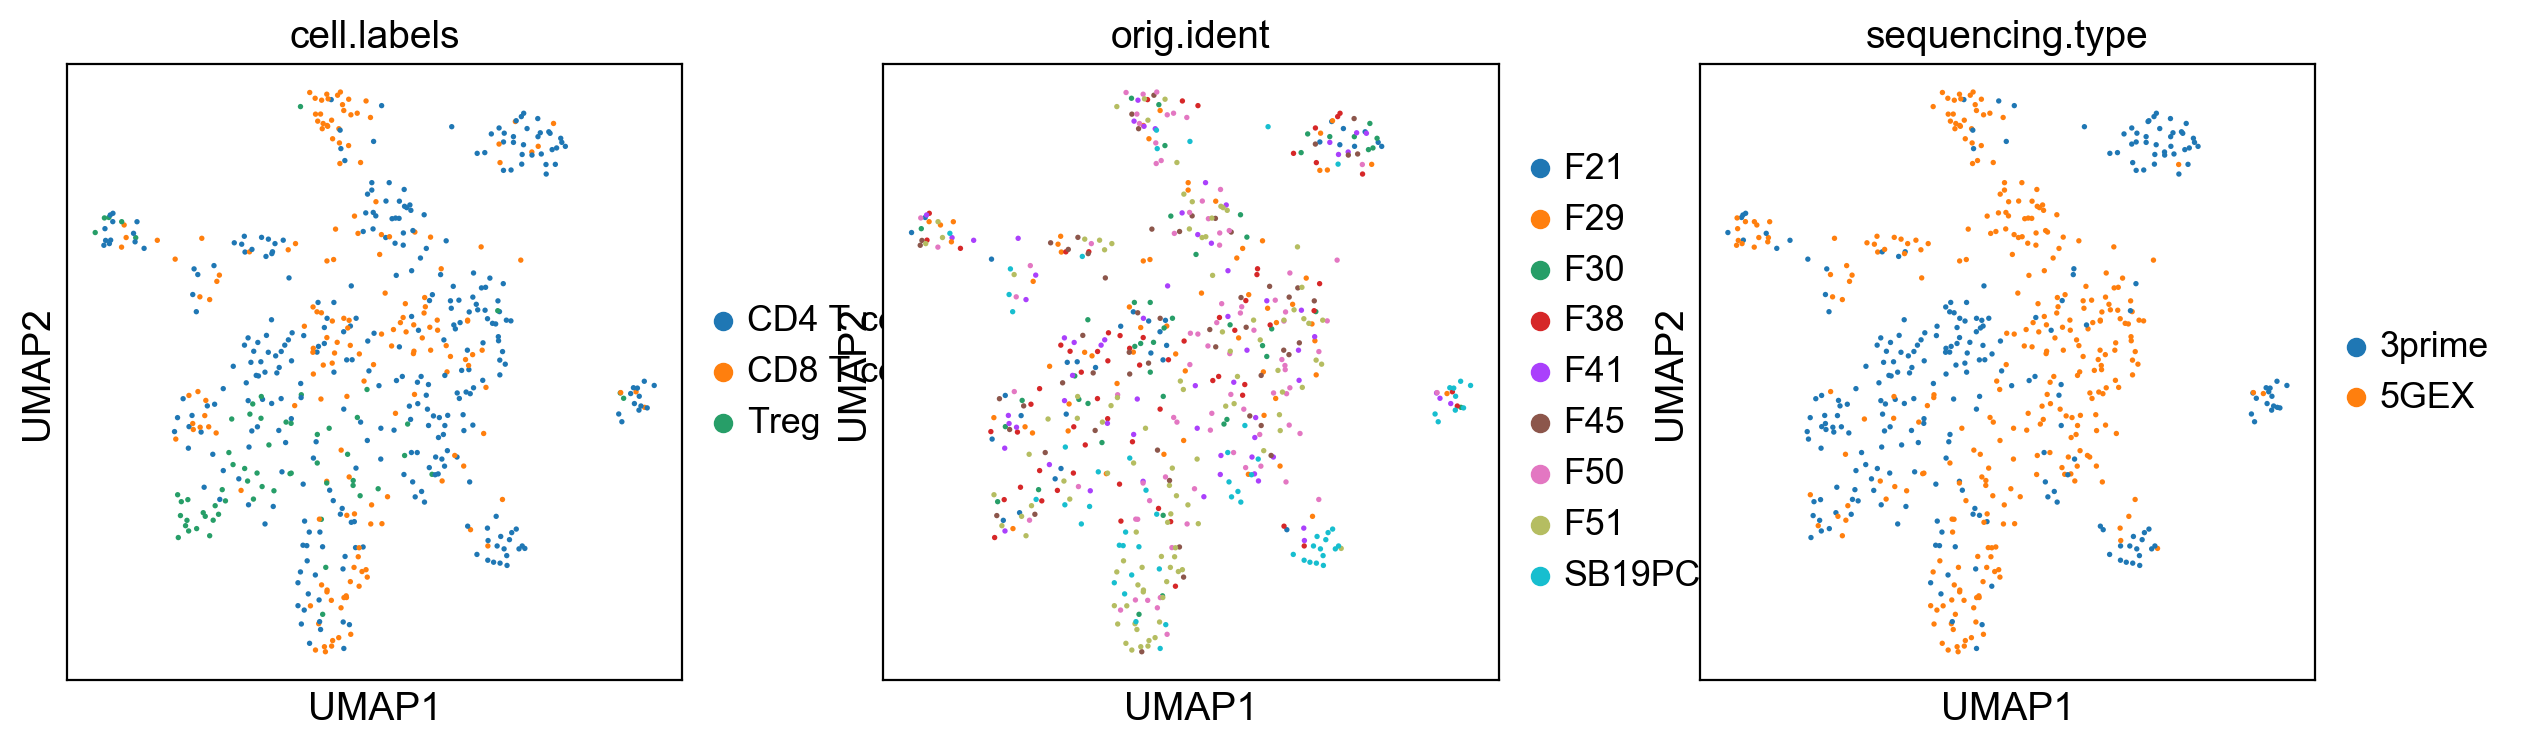

In [25]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels', 'orig.ident', 'sequencing.type'], size=15) 

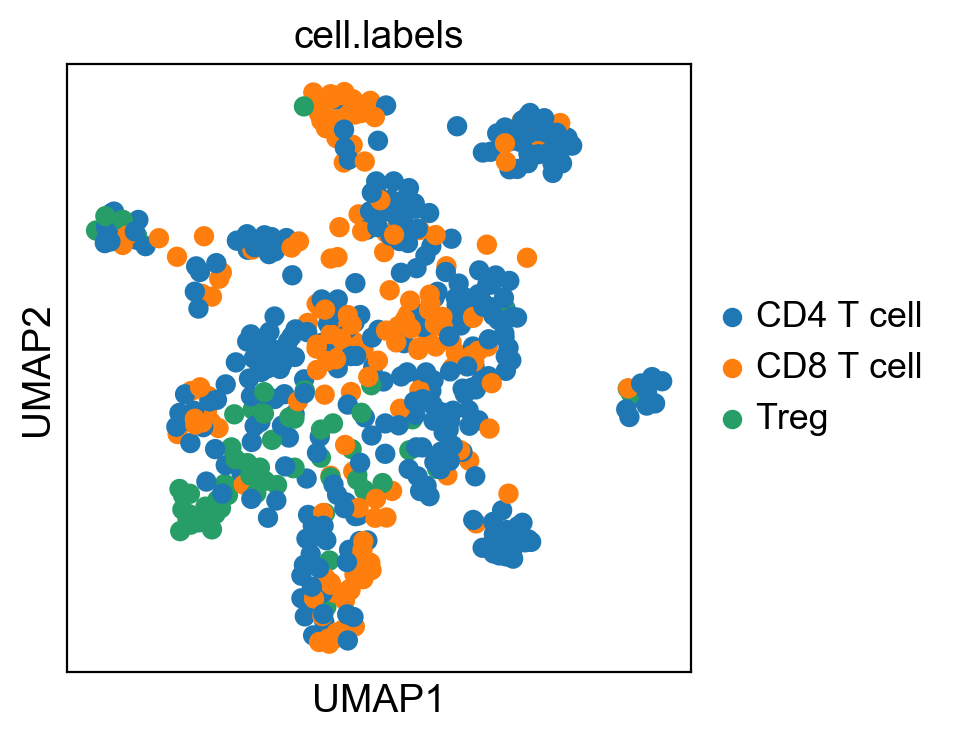

In [26]:
sc.pl.umap(adata, color='cell.labels', save = "tcell_umap_20210326.pdf")

# Subset FBM T cell data to that which we have VDJ data for

In [27]:
adata = adata[adata.obs['orig.ident'].isin(['F50', 'F51', 'F29', 'F30'])].copy()

In [28]:
adata.shape

(286, 33712)

In [29]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell    141
CD8 T cell    108
Treg           37
dtype: int64

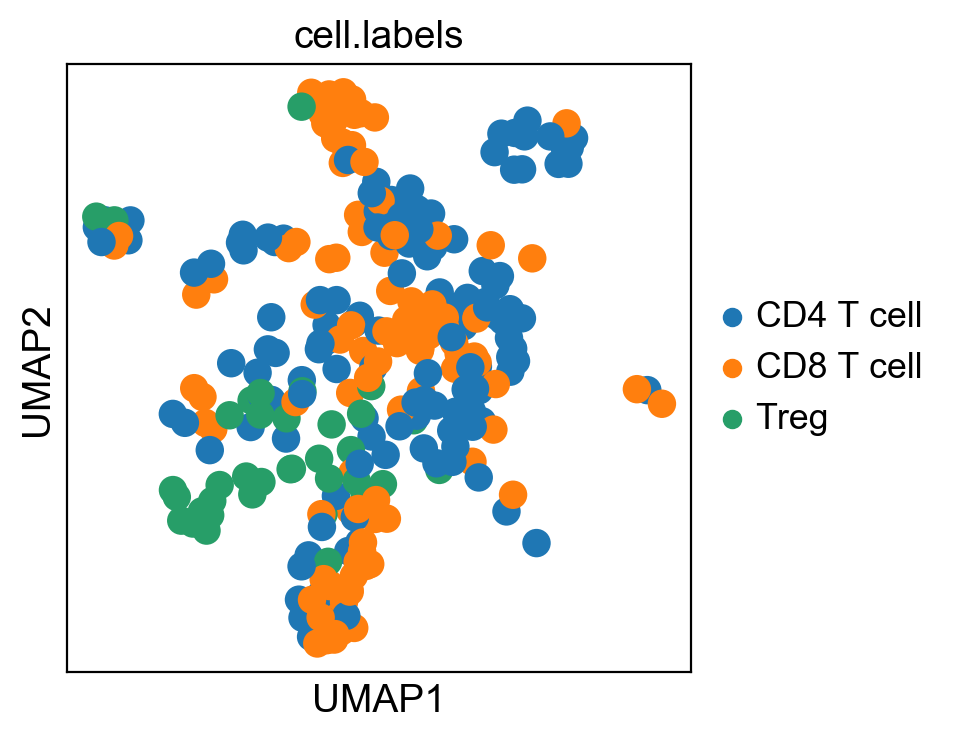

In [30]:
sc.pl.umap(adata, color='cell.labels', use_raw=False, save = "tcell_umap_20210326_vdjcells.pdf")

# Load VDJ data

### Load the  VDJ data in (using a manifest to match to their GEX pair)

To load in the VDJ data, we construct filepaths and a dictionary linking files to sample names. The easiest way is to prepare a manifest that lists the GEX sample names next to the V(D)J 10x directory names in a csv file.

We have seven lanes of TCR enriched VDJ data and five lanes of BCR enriched VDJ data 

In [31]:
# set the path for the manifest/vdj_data_files and the columns for the T and B cell enrichment
adata_GEX_lanes_name = 'lanes'

manifest = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/bm/figs/counts/10x_lane_info.csv")
manifest_GEX_lanes_col = 'SANGER.SAMPLE.IDs'
manifest_B_cell_enrichment_col = 'B_cell_enrichment'
manifest_T_cell_enrichment_col = 'T_cell_enrichment'

vdj_data_path = '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/'
vdj_figs_path = '/Users/b8058304/Documents/PhD_work/Coding/bm/figs/vdj/'

In [32]:
manifest = manifest[manifest[manifest_GEX_lanes_col].isin(adata.obs[adata_GEX_lanes_name].unique())]  # keep the ones in adata
manifest

,SANGER.SAMPLE.IDs,SAMPLE.NAME,Organ,Sequencing,Passed,AnnatomicalPart,T_cell_enrichment,B_cell_enrichment
3,FCAImmP7277558,F29_BM_CD45P,boneMarrow,3prime,True,Femur,NaN,NaN
4,FCAImmP7277567,F30_BM_CD45N,boneMarrow,3prime,True,Femur,NaN,NaN
5,FCAImmP7277566,F30_BM_CD45P,boneMarrow,3prime,True,Femur,NaN,NaN
12,FCAImmP7292031,F29_BM_TOT_2,boneMarrow,5GEX,True,Femur,FCAImmP7292944,NaN
13,FCAImmP7292035,F30_BM_TOT_2,boneMarrow,5GEX,True,Femur,FCAImmP7292947,NaN
20,FCAImmP7803016,F50_BM_CD45P_5,boneMarrow,5GEX,True,unknown,FCAImmP7812643,FCAImmP7812647
21,FCAImmP7803017,F50_BM_CD45P_6,boneMarrow,5GEX,True,unknown,FCAImmP7812644,FCAImmP7812648
23,FCAImmP7803032,F51_BM_CD45N_2,boneMarrow,5GEX,True,unknown,NaN,NaN
25,FCAImmP7803028,F51_BM_CD45P_7,boneMarrow,5GEX,True,unknown,FCAImmP7812653,FCAImmP7812658
26,FCAImmP7803029,F51_BM_CD45P_8,boneMarrow,5GEX,True,unknown,FCAImmP7812654,FCAImmP7812659


In [33]:
manifest = manifest[manifest[manifest_T_cell_enrichment_col].notnull()]  # can remove samples which have no VDJ (we have VDJ for all GEX)
# Construct paths to VDJ csv files:
paths = vdj_data_path + manifest[manifest_T_cell_enrichment_col] + '/filtered_contig_annotations.csv'
# Construct paths to VDJ csv files:
samples = dict(zip(paths, manifest[manifest_GEX_lanes_col]))
samples

{'/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7292944/filtered_contig_annotations.csv': 'FCAImmP7292031',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7292947/filtered_contig_annotations.csv': 'FCAImmP7292035',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812643/filtered_contig_annotations.csv': 'FCAImmP7803016',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812644/filtered_contig_annotations.csv': 'FCAImmP7803017',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812653/filtered_contig_annotations.csv': 'FCAImmP7803028',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812654/filtered_contig_annotations.csv': 'FCAImmP7803029',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812655/filtered_contig_annotations.csv': 'FCAImmP7803030'}

##### Prepare metadata column in adata object

The AnnData object must contain a metadata column (e.g. `adata.obs['vdj_obs']`) of the following format: `cellbarcode + '_' + lane`. This can be constructed from the cell barcodes and lane names (provided that we have sample annotation):

We then read V(D)J data into the AnnData object and create annotations. Note that values in the `filtered_contig_annotations.csv` files cannot be directly added as annotations, because one cell may have 0 to n values per entry. It will be stored in `adata.uns` and annotation will be generated separately.

Also note that the nomenclature used for the barcodes in `adata.obs['vdj_obs']` slot must match the nomenclature used for barcodes stored in `adata.uns['pyvdj']['df']['barcode']` later on in this notebook

In [34]:
cellnames = adata.obs_names
cellnames

Index(['F29_boneMarrow_Total_FCAImmP7292031_5GEX_TCGGGACCACGGTTTA', 'F29_boneMarrow_Total_FCAImmP7292031_5GEX_TGAAAGAAGGGTTCCC', 'F29_boneMarrow_Total_FCAImmP7292031_5GEX_TGCGTGGGTAAGGGAA', 'F50_boneMarrow_CD45+_FCAImmP7803017_5GEX_CTACACCCACATTTCT', 'F29_boneMarrow_CD45+_FCAImmP7277558_3prime_ACGCCGAAGAATTGTG', 'F29_boneMarrow_CD45+_FCAImmP7277558_3prime_ATCTGCCAGCTGCCCA', 'F29_boneMarrow_CD45+_FCAImmP7277558_3prime_CACAGTATCGTACGGC', 'F29_boneMarrow_CD45+_FCAImmP7277558_3prime_CACCTTGAGACCGGAT', 'F29_boneMarrow_CD45+_FCAImmP7277558_3prime_CCACGGATCGCTAGCG', 'F29_boneMarrow_CD45+_FCAImmP7277558_3prime_CCTATTAAGCGATCCC',
       ...
       'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GTAACTGGTAAGTTCC', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GTAGTCACACGAAAGC', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_GTGTTAGTCAACGGGA', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_TAGACCAGTCTAGAGG', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_TATCAGGGTATAGGGC', 'F51_boneMarrow_CD45+_FCAImmP7803030_5GEX_TCGTAG

In [35]:
cellnames = adata.obs_names
cellbarcode = cellnames.str.split("_").str[5:6].str.join("-") # cell barcode part + '-1'
adata.obs['vdj_obs'] = cellbarcode.astype(str) + "-1_" + adata.obs['lanes'].astype(str)

##### Load data

In [36]:
adata = pyvdj.load_vdj(samples, adata, obs_col='vdj_obs', cellranger=2)

In [37]:
len(adata.uns["pyvdj"]["df"]["clonotype_meta"].unique())

2116

This loaded 10x V(D)J sequencing data (i.e. filtered_contig_annotations.csv files) into adata.uns['pyvdj']. `obs_col` specifies the annotation column for cellnames, as prepared above. For Cell Ranger version 3, set the parameter to 3.
For definitions of some words (clone, clonotype etc) used in the next section, see https://github.com/veghp/pyVDJ.

# Add in clonotype and productivity metadata

This generates annotation in `adata.obs`. Now we can plot V(D)J properties:

This will show whether we have VDJ data for a cell we have captured in the GEX. It will also show if that cell is a clone (a cell whose TCR is identical to another cell, within the same individual (donor, organism)) and if it is productive (produces a TCR/BCR at protein level)

In [38]:
adata = pyvdj.add_obs(adata, obs=['clonotype', 'is_clone'])

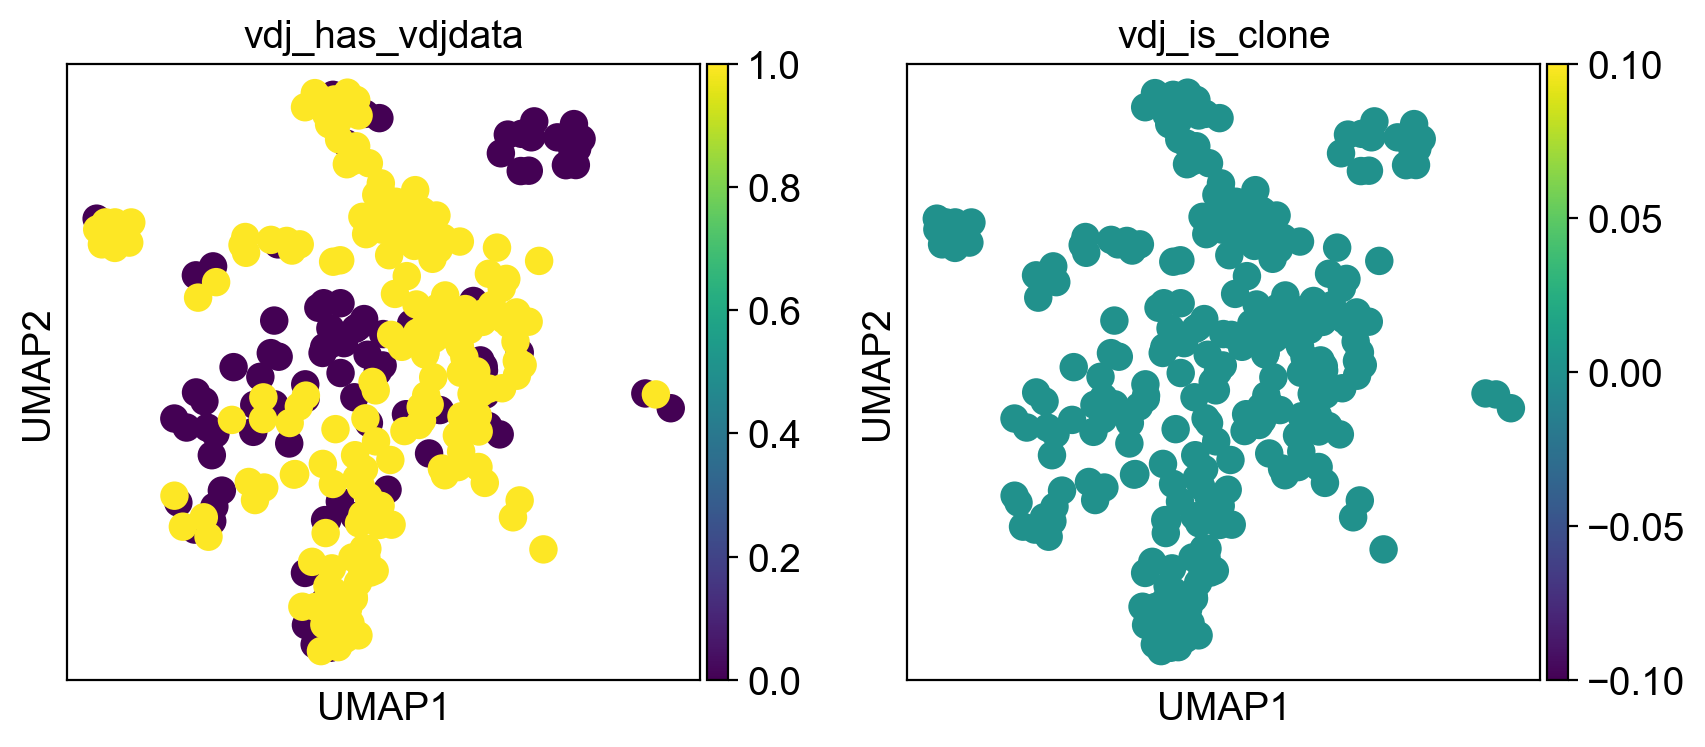

In [39]:
# When running on BCR data, we see the clones are restricted to the B lymphoid cells
sc.pl.umap(adata, color=['vdj_has_vdjdata', 'vdj_is_clone'])

In [40]:
allcell = len(adata.obs['vdj_has_vdjdata'])
vdjcell = sum(adata.obs['vdj_has_vdjdata'])
print('We have %d cells with VDJ data, out of %d cells.' % (vdjcell, allcell))

We have 194 cells with VDJ data, out of 286 cells.


In [41]:
adata.obs['vdj_is_clone'].dtype

dtype('bool')

In [42]:
df = pd.DataFrame({'count' : adata.obs.groupby(["vdj_is_clone", "cell.labels", "orig.ident"]).size()}).reset_index()
clone_df = df[df["vdj_is_clone"]==True]
clone_df

,vdj_is_clone,cell.labels,orig.ident,count


In [43]:
df = pd.DataFrame({'count' : adata.obs.groupby(["vdj_is_clone", "cell.labels", "orig.ident", "vdj_clonotype"]).size()}).reset_index()
clone_df = df[df["vdj_is_clone"]==True]
clone_df

,vdj_is_clone,cell.labels,orig.ident,vdj_clonotype,count


In [44]:
is_clone = sum(adata.obs['vdj_is_clone'])
print('We have %d cells with clones, out of %d cells.' % (is_clone, allcell))

We have 0 cells with clones, out of 286 cells.


In [45]:
# productivity = if all productive, all chains (poss 1 - 4) productive. protein coming from the rna.
adata = pyvdj.add_obs(adata, obs=['all_productive', 'any_productive'])

In [46]:
adata.uns['vdj_any_productive_colors'] = ['#1f77b4', '#ff0000']

In [47]:
new = adata[~adata.obs['vdj_has_vdjdata'].isin(['0'])].copy()

... storing 'vdj_all_productive' as categorical
... storing 'vdj_any_productive' as categorical


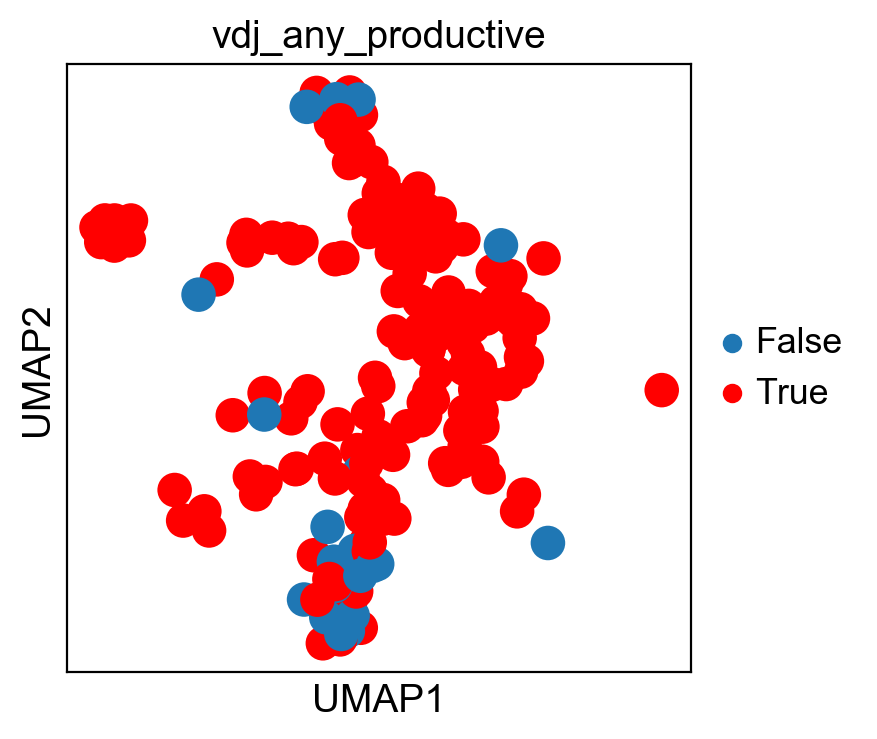

In [48]:
sc.pl.umap(new, color=['vdj_any_productive'], save="tcell_productive_20210326.pdf")

In [49]:
adata.obs.groupby(['vdj_any_productive']).apply(len)

vdj_any_productive
False     21
True     173
dtype: int64

In [50]:
cell_numbers = adata.obs.groupby(["cell.labels", "vdj_any_productive"]).apply(len)
cell_numbers

cell.labels  vdj_any_productive
CD4 T cell   False                  5
             True                  80
CD8 T cell   False                 13
             True                  68
Treg         False                  3
             True                  25
dtype: int64

In [51]:
cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_any_productive"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_productivity_20210326.csv")
cell_numbers

cell.labels  orig.ident  vdj_any_productive
CD4 T cell   F29         True                  25
             F30         True                   5
             F50         True                  19
             F51         False                  5
                         True                  31
CD8 T cell   F29         True                  11
             F30         True                  10
             F50         False                  2
                         True                  22
             F51         False                 11
                         True                  25
Treg         F29         True                   3
             F30         True                   2
             F50         True                   4
             F51         False                  3
                         True                  16
dtype: int64

# Add in in chain type metadata

In [52]:
# The following command adds one boolean metnew column (in new.obs) for each type of chain found in the V(D)J data:
new = pyvdj.add_obs(new, obs=['chains'])

Multi
IGK
IGH
TRG
TRA
TRB
IGL
TRD
None


In [53]:
del new.obs["vdj_chain_IGL"]
del new.obs["vdj_chain_IGH"]
del new.obs["vdj_chain_IGK"]

In [54]:
new.obs["ig_chains"] = new.obs["vdj_chain_TRA"].astype(str) + '_' + new.obs["vdj_chain_TRB"].astype(str) + '_' + new.obs["vdj_chain_TRD"].astype(str) + '_' + new.obs["vdj_chain_TRG"].astype(str)
new.obs["vdj_ig_chains"] = new.obs["ig_chains"] 

... storing 'ig_chains' as categorical
... storing 'vdj_ig_chains' as categorical


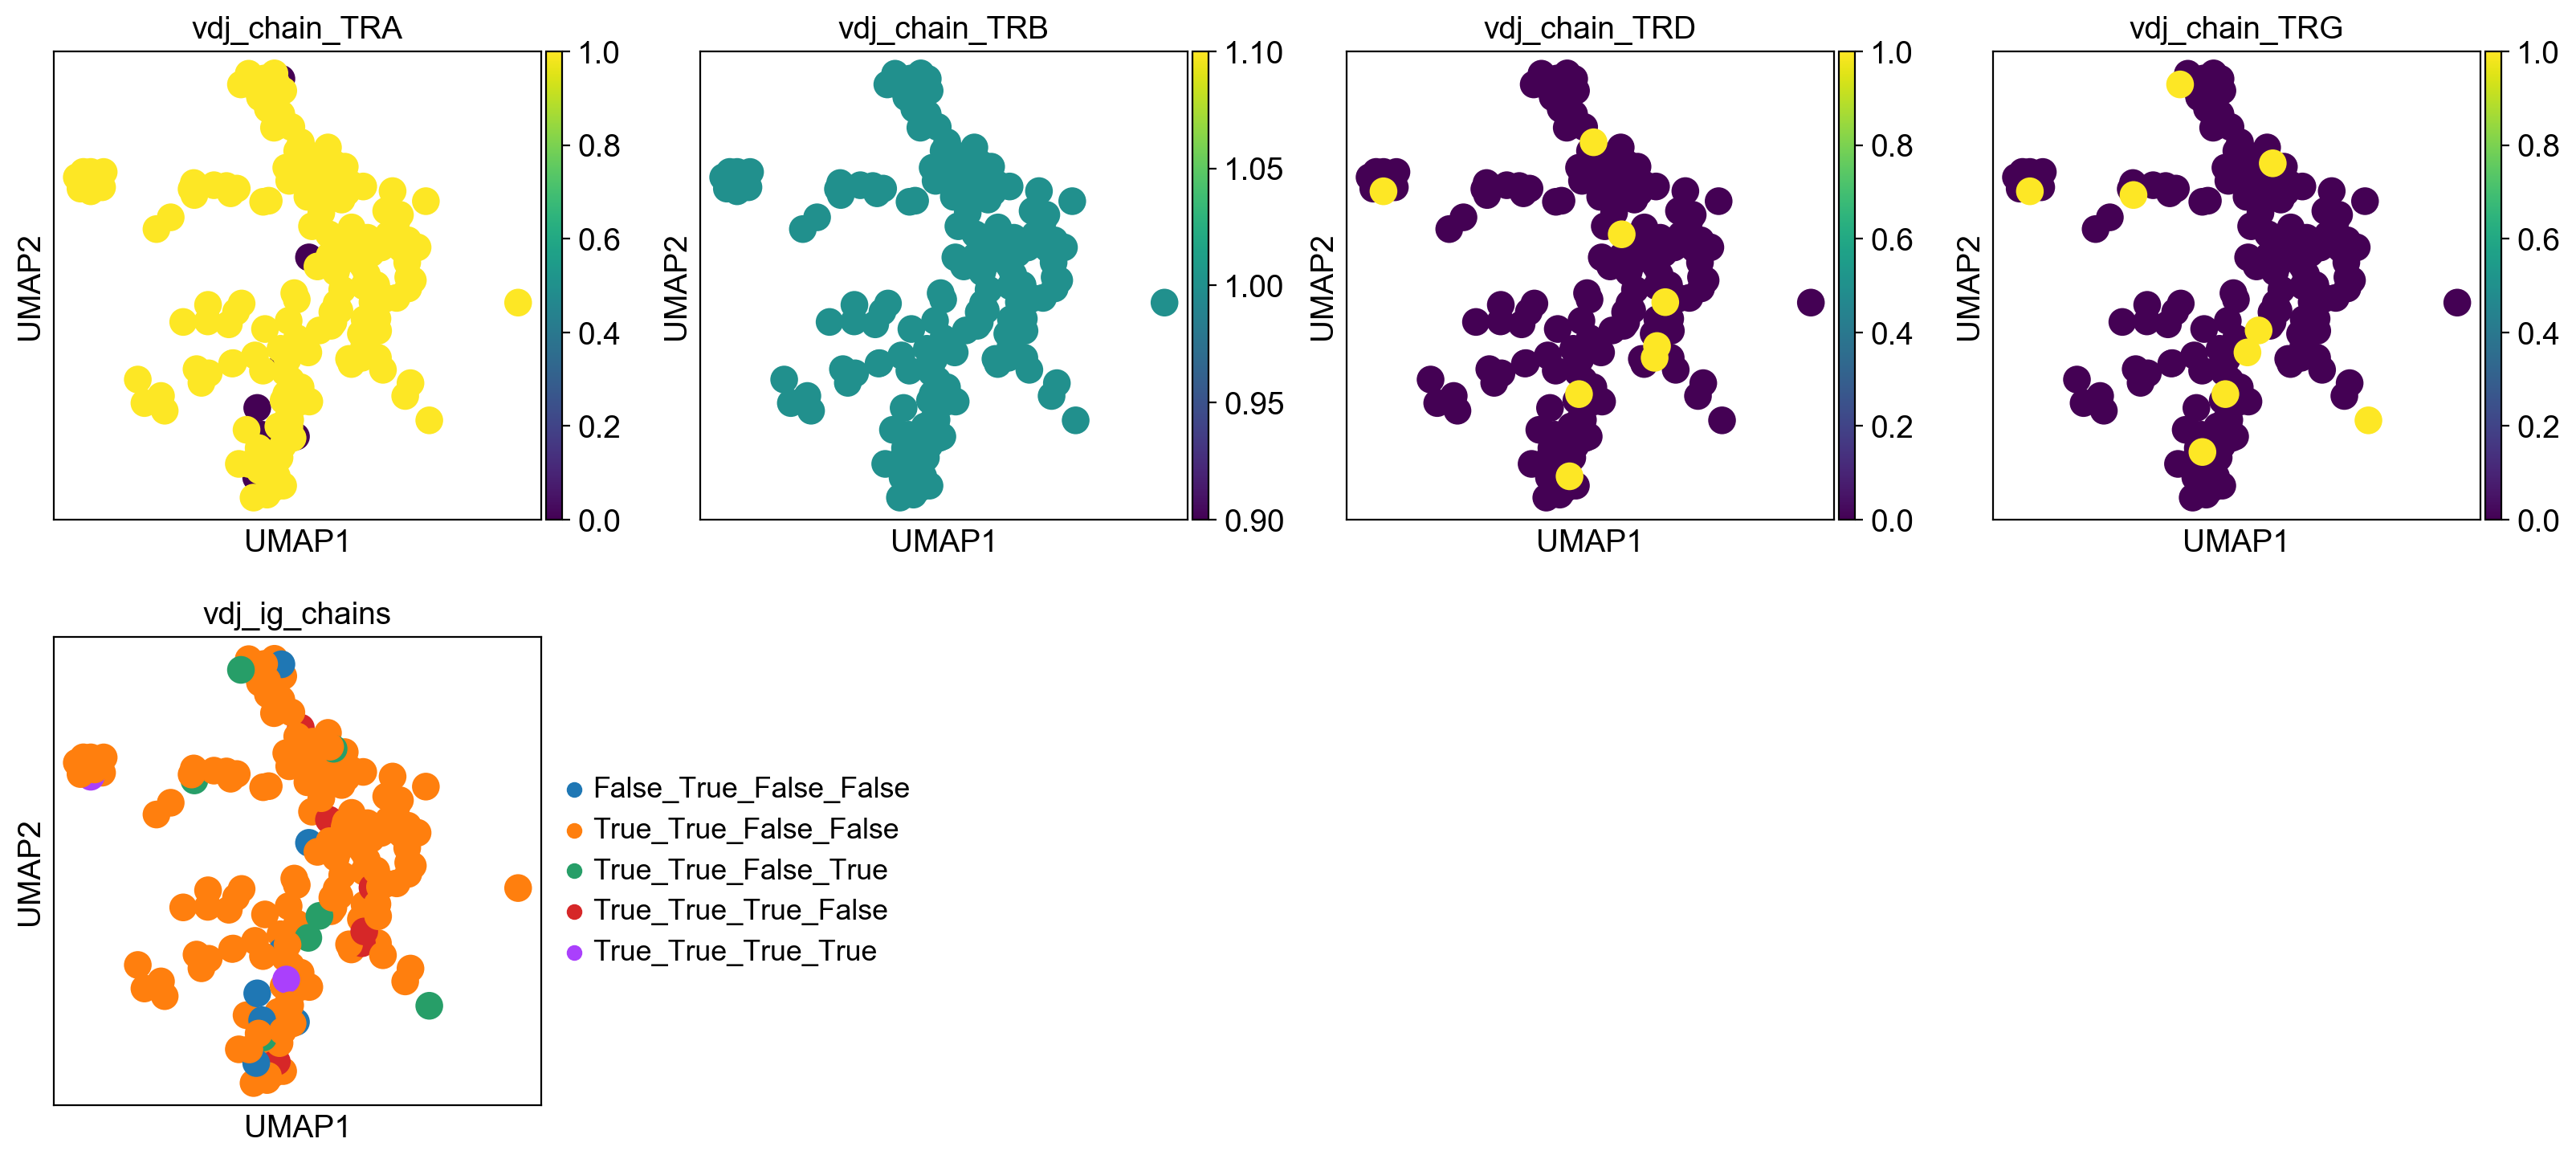

In [55]:
sc.pl.umap(new, color=['vdj_chain_TRA', 'vdj_chain_TRB', 'vdj_chain_TRD', 'vdj_chain_TRG', 'vdj_ig_chains'])

In [56]:
chain_list = ["False_False_False_False", "False_True_False_False", "False_True_False_True", "False_True_True_False", "No_data_No_data_No_data_No_data", "True_False_False_False", "True_True_False_False", "True_True_False_True", "True_True_True_False", "True_True_True_True"]
chain_list_new = ["no_chains", "TRB", "TRB+G", "TRB+D", "no_vdj_data", "TRA", "TRA+B", "TRA+B+G", "TRA+B+D", "TRA+B+D+G"]

In [57]:
new.obs["vdj_ig_chains"] = new.obs["vdj_ig_chains"].replace(chain_list, chain_list_new)
new.obs["vdj_ig_chains"] = new.obs["vdj_ig_chains"].astype("category")
new.uns['vdj_ig_chains_colors'] = ['#000000', '#800080', '#d200d2', '#0000ff', '#ff0000', '#00d200', '#00d6ff', '#9c9c9c', '#ececec']

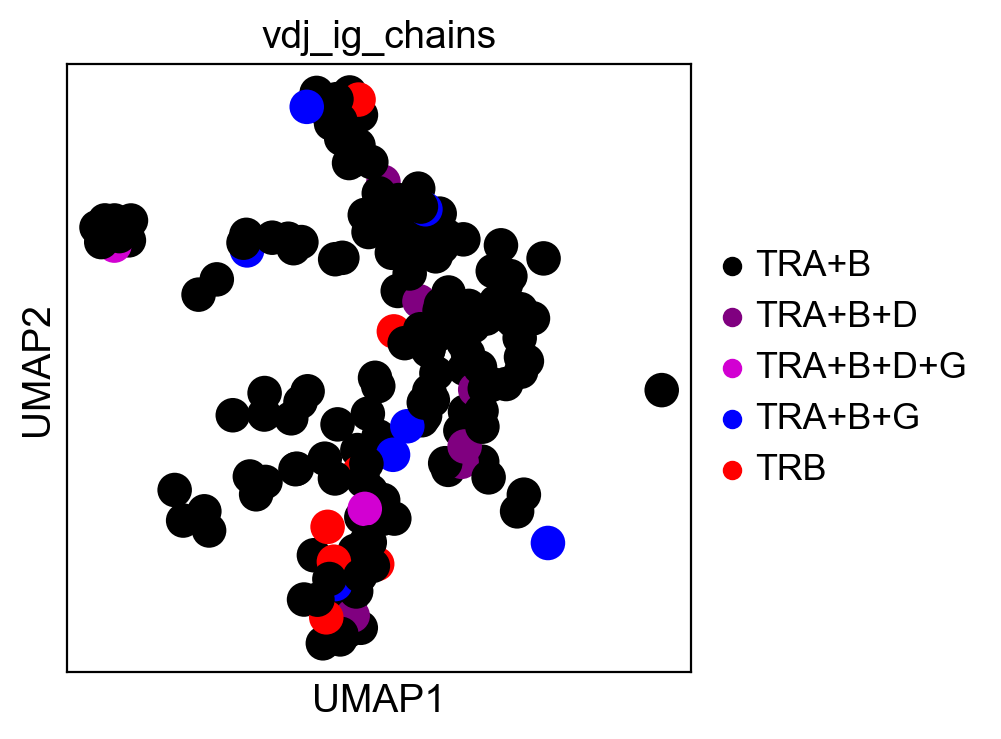

In [58]:
sc.pl.umap(new, color='vdj_ig_chains')

In [59]:
new.obs.groupby(['vdj_ig_chains']).apply(len)

vdj_ig_chains
TRA+B        171
TRA+B+D        6
TRA+B+D+G      2
TRA+B+G        7
TRB            8
dtype: int64

In [60]:
new.obs.groupby(['vdj_chain_TRD']).apply(len)

vdj_chain_TRD
False    186
True       8
dtype: int64

In [61]:
new.obs.groupby(['vdj_chain_TRG']).apply(len)

vdj_chain_TRG
False    185
True       9
dtype: int64

In [62]:
new.obs.groupby(['vdj_chain_TRA']).apply(len)

vdj_chain_TRA
False      8
True     186
dtype: int64

In [63]:
new.obs.groupby(['vdj_chain_TRB']).apply(len)

vdj_chain_TRB
True    194
dtype: int64

# Plot chain info as UMAPs

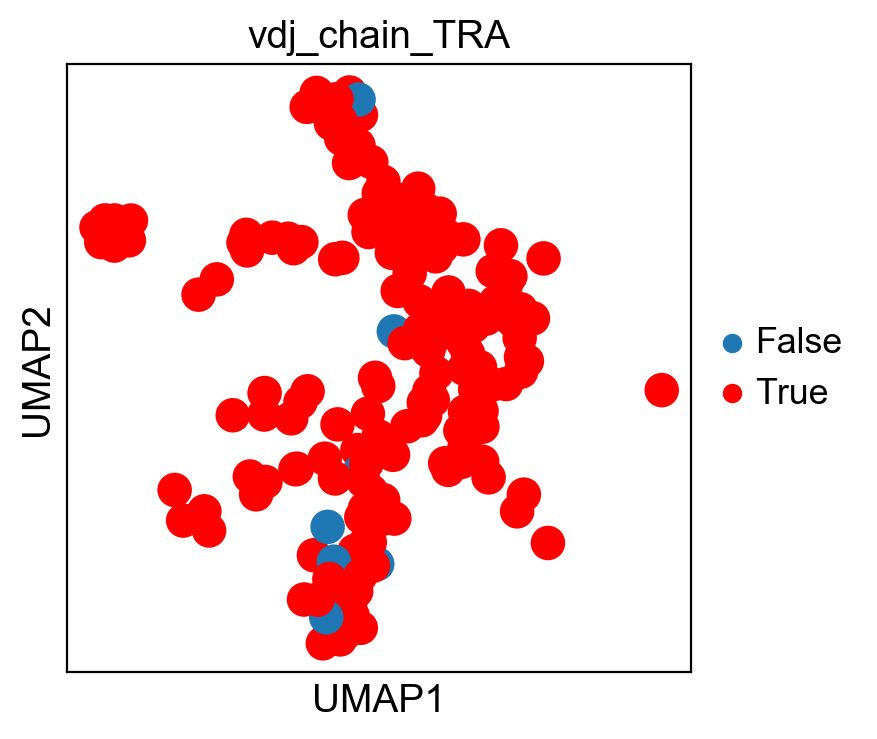

In [64]:
new.obs["vdj_chain_TRA"] = new.obs["vdj_chain_TRA"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRA", "no_data", "TRA_detected"]

new.obs["vdj_chain_TRA"] = new.obs["vdj_chain_TRA"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRA']).apply(len)

new.uns['vdj_chain_TRA_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRA', save = "tcell_vdj_traa_20210326.pdf")

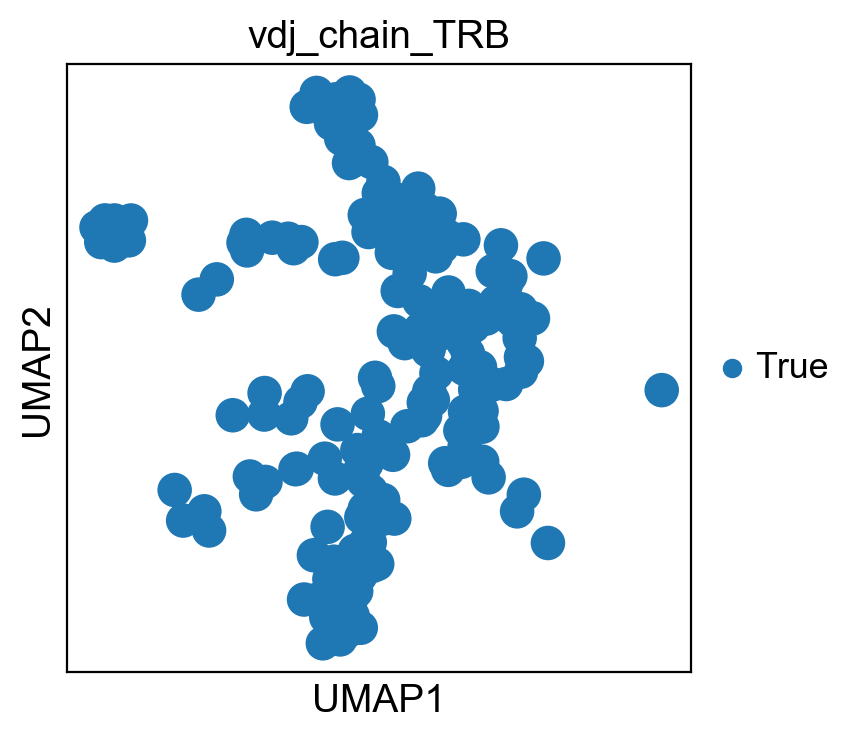

In [65]:
new.obs["vdj_chain_TRB"] = new.obs["vdj_chain_TRB"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRB", "no_data", "TRB_detected"]

new.obs["vdj_chain_TRB"] = new.obs["vdj_chain_TRB"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRB']).apply(len)

new.uns['vdj_chain_TRB_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRB', save = "tcell_vdj_trb_20210326.pdf")

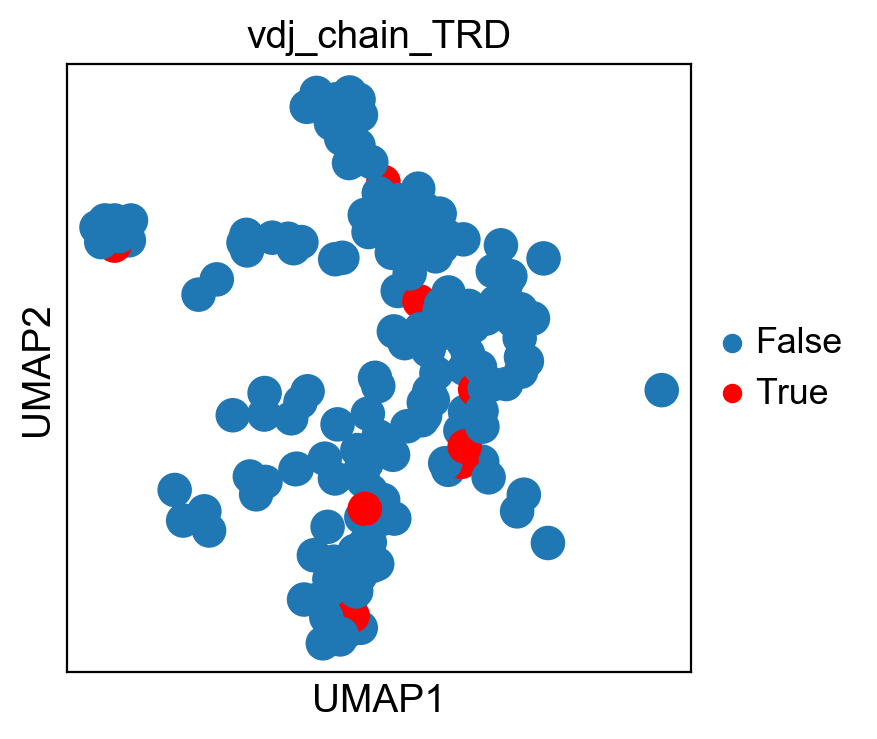

In [66]:
new.obs["vdj_chain_TRD"] = new.obs["vdj_chain_TRD"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRD", "no_data", "TRD_detected"]

new.obs["vdj_chain_TRD"] = new.obs["vdj_chain_TRD"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRD']).apply(len)

new.uns['vdj_chain_TRD_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRD', save = "tcell_vdj_trd_20210326.pdf")

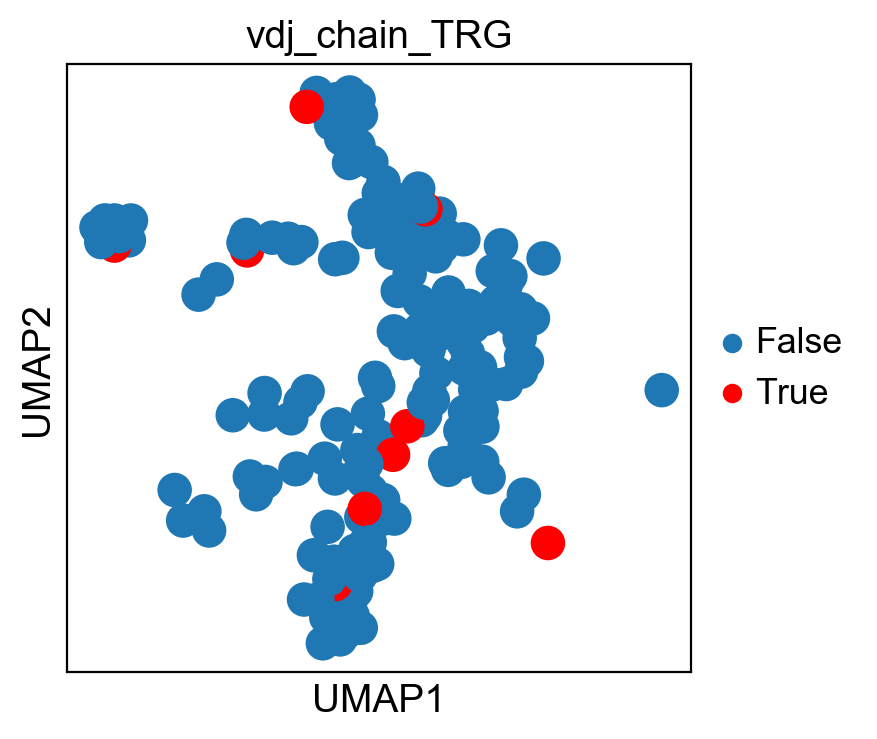

In [67]:
new.obs["vdj_chain_TRG"] = new.obs["vdj_chain_TRG"].astype("category")

chain_list = ["False", "No_data", "True"]
chain_list_new = ["no_TRG", "no_data", "TRG_detected"]

new.obs["vdj_chain_TRG"] = new.obs["vdj_chain_TRG"].replace(chain_list, chain_list_new)
new.obs.groupby(['vdj_chain_TRG']).apply(len)

new.uns['vdj_chain_TRG_colors'] = ['#1f77b4', '#ff0000']

sc.pl.umap(new, color='vdj_chain_TRG', save = "tcell_vdj_trg_20210326.pdf")

In [68]:
adata = new

# Save chain info as csvs

In [69]:
cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRA"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRA_20210326.csv")

cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRB"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRB_20210326.csv")

cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRD"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRD_20210326.csv")

cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_chain_TRG"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRG_20210326.csv")

In [70]:
cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRA"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRA_productive_20210326.csv")

cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRB"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRB_productive_20210326.csv")

cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRD"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRD_productive_20210326.csv")

cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_chain_TRG"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/tcell_vdj_chains_TRG_productive_20210326.csv")